# Project Part 2 Solutions

## (a)

In [12]:
import numpy as np

file=np.load("part2.npz")
beta_old=file['beta_old']
N=file['N']
Svc_0_PMF=file['Svc_0_PMF']
Lc=file['Lc']
Ic_0=file['Ic_0']
gamma=file['gamma']
L_observed=file['L_observed']
nb_nodes = Svc_0_PMF.shape[0]

array(0.07142857)

In [2]:
def SIR(t, Z, N, betas, gamma):
    (S_vec, I_vec, R) = (Z[:16].reshape(4, 4), Z[16:20], Z[-1])
    I = I_vec.sum()
    dSdt = -betas*S_vec*I/N 
    dIdt = -dSdt.sum(axis=0)-gamma*I_vec
    dRdt = np.array([gamma*I])
    return np.concatenate((dSdt.flatten(), dIdt, dRdt))

In [22]:
from scipy.integrate import solve_ivp
from scipy.optimize import fmin
from sklearn.metrics import mean_squared_error

Svc_0_PMF /= Svc_0_PMF.sum(axis=(1, 2), keepdims=True)
Svc_0 = (N-Ic_0.sum(axis=1))[:, np.newaxis, np.newaxis]*Svc_0_PMF
Svc_0 = Svc_0.round().astype(int)
R0 = np.zeros((nb_nodes)).astype(int)

t = np.linspace(0, 199, 200)

S = np.zeros((nb_nodes, 4, 4, len(t)))
I = np.zeros((nb_nodes, 4, len(t)))
R = np.zeros((nb_nodes, len(t)))
L = np.zeros((nb_nodes, len(t)))

for N_node, node_index in zip(N, range(nb_nodes)):

    initial_conditions = np.concatenate(
        (Svc_0[node_index].flatten(), Ic_0[node_index], [R0[node_index]]))

    soln = solve_ivp(
        SIR, (t[0], t[9]), initial_conditions, args=(N_node, beta_old, gamma), t_eval=t[:10])

    S[node_index, :, :, :10] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, :10] = soln.y[16:20]
    R[node_index, :10] = soln.y[20]
    L[node_index, :10] = Lc@soln.y[16:20]


alpha_predicted = np.zeros((nb_nodes))


def loss_func(alpha):
    new_initial_conditions = np.concatenate((S[node_index,:,:,9].flatten(), I[node_index,:,9], [R[node_index,9]]))
    soln = solve_ivp(
        SIR, (t[9],t[30]), new_initial_conditions,args=(N_node,beta_old*alpha,gamma),t_eval=t[9:30])

    S[node_index, :, :, 9:30] = soln.y[:16].reshape(4, 4, -1)
    I[node_index, :, 9:30] = soln.y[16:20]
    R[node_index, 9:30] = soln.y[20]
    L[node_index, 9:30] = Lc@soln.y[16:20]
    mse = mean_squared_error(L_observed[node_index, 9:30], L[node_index][9:30])
    return mse

for N_node, node_index in zip(N, range(nb_nodes)):
    alpha_predicted[node_index] = fmin(loss_func, 0.5, disp=False)

print("Sorted alpha values are ", np.sort(alpha_predicted),'\n')
print("Indexes of nodes sorted by alpha values are", np.argsort(alpha_predicted))

Sorted alpha values are  [0.13437347 0.14959717 0.15996704 0.16158829 0.16306152 0.16851807
 0.17086182 0.17155762 0.17612305 0.17961426 0.18221436 0.18603516
 0.18710937 0.19025879 0.20031738 0.20330505 0.20419922 0.20612793
 0.20684509 0.2128418  0.21408691 0.2162323  0.21859131 0.22739258
 0.23042603 0.23352203 0.24157715 0.24465332 0.24894104 0.25119629
 0.25798035 0.25991821 0.26757812 0.26948242 0.27169952 0.27301636
 0.28005524 0.28283691 0.28662109 0.28800049 0.2930542  0.2992981
 0.29938354 0.30321045 0.30422821 0.30437317 0.30966797 0.31420898
 0.32382202 0.3296875  0.32988281 0.33074341 0.33313293 0.33355408
 0.3498291  0.35234375 0.35657806 0.35756836 0.35844421 0.36207275
 0.36960449 0.37071838 0.37946777 0.38393707 0.3860054  0.39033203
 0.40922546 0.41445465 0.41787415 0.41876221 0.42476807 0.43438721
 0.43756104 0.44870605 0.44996338 0.45647888 0.47091064 0.48615723
 0.5023941  0.50705566 0.50830688 0.52108459 0.53604736 0.55296021
 0.55423279 0.56278687 0.58075714 0.59

## (b)

In [28]:
def g(money):
    alpha = 1/np.log2(2*10**(-3)*money+2)
    return alpha

def g_inv(alpha):
    money = (2**(1/alpha)-2)/(2*10**(-3))
    return money

def scatter_plot(alpha_afterNPI):
    plt.figure()
    colors=(beta_old[np.newaxis,:,:]*Svc_0_PMF).mean(axis=(1,2))
    plt.scatter(alpha_predicted, alpha_afterNPI, s=N/500, c=colors, cmap='jet', alpha=0.5)
    plt.xlabel(r"$\alpha_{own}$")
    plt.ylabel(r"$\alpha_{after\ NPI}$")

def total_recovered_difference(alpha_afterNPI):
    # difference between teh summation of people recovered after 200 days 
    # in all the nodes using alpha_afterNPI or using old alpha after Day 30.
    difference = 0
    for N_node, node_index in zip(N, range(nb_nodes)):
        i_conditions = np.concatenate((S[node_index,:,:,29].flatten(), I[node_index,:,29], [R[node_index,29]]))
        soln_alpha_old = solve_ivp(SIR, (t[29],t[199]), i_conditions,args=(N_node,beta_old*alpha_predicted[node_index],gamma),t_eval=t[29:199])
        soln_alpha_new = solve_ivp(SIR, (t[29],t[199]), i_conditions,args=(N_node,beta_old*alpha_afterNPI[node_index],gamma),t_eval=t[29:199])
        difference += soln_alpha_new.y[-1][-1] - soln_alpha_old.y[-1][-1]  # number of recovered population on last day
    return difference

def calculate_alpha_after(alpha_own, money):
    return g(g_inv(alpha_own)+money)

### Policy #1

i. The larger the alpha_own is, the larger alpha_after is.

ii.

When applying policy 1, total recovered difference is  -320300.82569705904


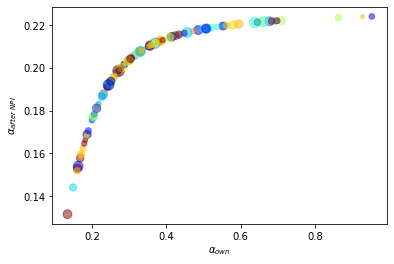

In [29]:
import matplotlib.pyplot as plt
import copy
alpha_policy1 = copy.deepcopy(alpha_predicted)
for i, v in enumerate(alpha_predicted):
    alpha_policy1[i] = calculate_alpha_after(v, 10000)
scatter_plot(alpha_policy1)
print("When applying policy {}, total recovered difference is ".format(1), total_recovered_difference(alpha_policy1))

### Policy #2

i. 

ii.

When applying policy 2, total recovered difference is  -335846.7291849529


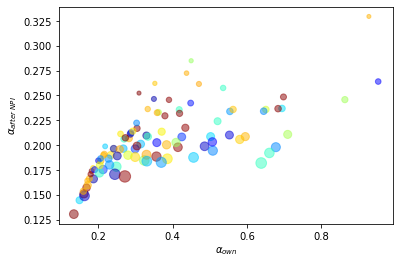

In [31]:
alpha_policy2 = copy.deepcopy(alpha_predicted)
n_portion = N/N.sum()
for i, v in enumerate(alpha_predicted):
    alpha_policy2[i] = calculate_alpha_after(v, n_portion[i]*1000000)

scatter_plot(alpha_policy2)
print("When applying policy {}, total recovered difference is ".format(2), total_recovered_difference(alpha_policy2))

### Policy #3

i.

ii.

### Policy #4

i.

ii.

## (c)

### Policy 1

### Policy 2

### Policy 3

### Policy 4